In [1]:
import pandas as pd
import numpy as np
import fitz

from bs4 import BeautifulSoup # for parse the html and find all url hrf with ".pdf" final

from langdetect import detect, DetectorFactory, detect_langs, lang_detect_exception #to recognize the language of the text
from collections import Counter
DetectorFactory.seed = 0

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sentence_transformers import SentenceTransformer
#from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from sklearn.neighbors import LocalOutlierFactor


/home/aditi/climate_change_policy_analysis/venv_climate/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

stopwords_dir = '/home/aditi/nltk_data/corpora/stopwords'
print('Stopwords dir exists?', os.path.isdir(stopwords_dir))
print('Files inside stopwords:', os.listdir(stopwords_dir) if os.path.isdir(stopwords_dir) else 'No dir found')


Stopwords dir exists? True
Files inside stopwords: ['catalan', 'danish', 'dutch', 'chinese', 'belarusian', 'greek', 'italian', 'portuguese', 'indonesian', 'finnish', 'hebrew', 'basque', 'spanish', 'swedish', 'slovene', 'nepali', 'tamil', 'romanian', 'hinglish', 'english', 'albanian', 'russian', 'hungarian', 'german', 'norwegian', 'kazakh', 'arabic', 'turkish', 'tajik', 'french', 'bengali', 'README', 'azerbaijani']


## Load the data

In [3]:
df = pd.read_csv('../data/CCLW.csv')
df

,Document ID,Document Title,Family ID,Family Title,Family Summary,Collection Title(s),Collection Description(s),Document Variant,Document Content URL,Language,...,Document Type,Category,Framework,Topic/Response,Hazard,Sector,Keyword,Instrument,Author,Author Type
0,ordinance-730-03-on-the-encouragement-of-the-p...,Ordinance 730.03 on the encouragement of the p...,ordinance-730-03-on-the-encouragement-of-the-p...,Ordinance 730.03 on the encouragement of the p...,<p>This regulation defines basic determination...,NaN,NaN,Original Language,https://www.fedlex.admin.ch/filestore/fedlex.d...,French;German,...,Regulation,Executive,NaN,Mitigation,NaN,Energy,Renewables;Electricity;Heat,"Processes, plans and strategies|Governance",NaN,NaN
1,green-construction-through-wood-program-applic...,Green Construction through Wood Program - APPL...,green-construction-through-wood-program_d7f2,Green Construction through Wood Program,<p>The Green Construction through Wood (GCWood...,NaN,NaN,Original Language,https://ostr-backend-prod.azurewebsites.net/se...,English,...,Programme,Executive,NaN,Mitigation,NaN,Buildings,Energy Demand;Energy Efficiency;Mitigation,Provision of climate funds|Direct Investment,NaN,NaN
2,product-emissions-standards-act_2677,Product Emissions Standards Act,product-emissions-standards-act-2017_7c97,Product Emissions Standards Act (2017),<p>This act establishes a national framework t...,NaN,NaN,Original Language,https://www.legislation.gov.au/C2017A00104/lat...,English,...,Act,Legislative,NaN,Mitigation,NaN,Industry;Energy;Agriculture;LULUCF,Energy Efficiency;Energy Demand,"Standards, obligations and norms|Regulation",NaN,NaN
3,national-steel-policy_5eeb,National steel policy,national-steel-policy_42a5,National steel policy,<p>the Government has come out with National S...,NaN,NaN,Original Language,https://steel.gov.in/national-steel-policy-nsp...,English,...,Policy,Executive,NaN,Mitigation,NaN,Industry,Mitigation,"Standards, obligations and norms|Regulation;Pr...",NaN,NaN
4,notification-s-o-2670-e-fuel-consumption-stand...,Notification S.O. 2670(E) - Fuel-Consumption S...,fuel-consumption-standards-for-heavy-duty-vehi...,Fuel-Consumption Standards for Heavy-Duty Vehi...,<p>India initially introduced fuel consumption...,NaN,NaN,Original Language,https://www.transportpolicy.net/wp-content/upl...,English;Hindi,...,Rules,Executive,NaN,Mitigation,NaN,Transport,Energy Efficiency,"Standards, obligations and norms|Regulation",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,national-decarbonization-plan-government-of-co...,National Decarbonization Plan - Government of ...,national-decarbonization-plan-government-of-co...,National Decarbonization Plan - Government of ...,National Decarbonization Plan - Government of ...,NaN,NaN,Translation,https://unfccc.int/sites/default/files/resourc...,English,...,Long-Term Low-Emission Development Strategy,UNFCCC,NaN,NaN,NaN,NaN,NaN,NaN,Costa Rica,Party
8970,national-clean-development-strategy-2020-2050_...,National Clean Development Strategy 2020-2050,national-clean-development-strategy-2020-2050_...,National Clean Development Strategy 2020-2050,"National Clean Development Strategy 2020-2050,...",NaN,NaN,NaN,https://unfccc.int/sites/default/files/resourc...,English,...,Long-Term Low-Emission Development Strategy,UNFCCC,NaN,NaN,NaN,NaN,NaN,NaN,Hungary,Party
8971,namibia-first-ndc-updated-submission_3c8d,Namibia First NDC (Updated submission),namibia-nationally-determined-contribution-ndc...,Namibia Nationally Determined Contribution. N...,"<p>Namibia First NDC (Updated submission), Nat...",Namibia's Nationally Determined Contributions,NaN,NaN,https://unfccc.int/sites/default/files/NDC/202...,English,...,Nationally Determined Contribution,UNFCCC,NaN,NaN,NaN,NaN,NaN,NaN,Namibia,Party
8972,myanmar-first-ndc-archived_8559,Myanmar First NDC (Archived),myanmar-nationally-determined-contribution-ndc...,Myanmar Nationally Determined Contribution. ND...,"<

In [4]:
df['Family Summary'].isna().sum() # Checking how many of the instances have a summary as that would be my point of text analysis

np.int64(30)

## Finding indicators
Check which other columns can be used as our indicator, based on the number of NaN values present.

In [5]:
df['Topic/Response'].isna().sum()

np.int64(2745)

In [6]:
df['Framework'].isna().sum()

np.int64(8473)

In [7]:
df['Category'].isna().sum()

np.int64(0)

In [8]:
df['Sector'].isna().sum()

np.int64(3207)

In [9]:
df['Keyword'].isna().sum()

np.int64(3933)

In [10]:
df['Instrument'].isna().sum()

np.int64(4209)

In [11]:
df['Hazard'].isna().sum()

np.int64(8528)

So we choose ```Topic/Response``` as our indicator variable. Therefore, we remove the rows which do not have any topic/response.

In [12]:
df = df[~df['Topic/Response'].isna()]

## Preparing the summary

First detect the language of the summary, as it will be useful during pre-processing.

In [13]:
def check_lang(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 'NA'
    try:
        return detect(text)
    except:
        return 'unknown'

In [14]:
df['Family Summary'].apply(lambda x: check_lang(x)).value_counts()

Family Summary
en    6209
es      11
fr       3
NA       3
tl       2
nl       1
Name: count, dtype: int64

Based on the languages we detect, we collect the stopwords and stemmers accordingly. I use NLTK stopwords + SnowballStemmer for the languages that are supported.

In [15]:
# Download nltk data
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')


supported_langs = ['english', 'romanian', 'spanish', 'french', 'italian', 'german', 'dutch', 'russian']
stopwords_dict = {lang: set(stopwords.words(lang)) for lang in supported_langs}
stemmers = {lang: SnowballStemmer(lang) for lang in supported_langs}

## Pre-processing the summaries

In [16]:
def preprocess_multilingual(text):
    # Handle NaN or empty strings
    if not isinstance(text, str) or len(text.strip()) == 0:
        return ''
    
    # Language detection (safe)
    try:
        lang = detect(text)
    except:
        lang = 'unknown'

    # Strip HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    clean_text = soup.get_text(separator=' ')
    
    # Normalize whitespace only (keep punctuation and case)
    clean_text = ' '.join(clean_text.split())

    ## Not performing punctuation removal and lowercasing, as those are useful bits of information for this study

    # If supported language, remove stopwords and stem
    if lang in supported_langs:
        sw = stopwords_dict[lang]
        stemmer = stemmers[lang]
        words = clean_text.split()
        # Remove stopwords (case insensitive) and stem words
        words = [stemmer.stem(w) for w in words if w.lower() not in sw and w.isalpha()]
        return ' '.join(words)
    else:
        # For unsupported languages, minimal cleaning, tokenize by whitespace, remove non-alpha tokens
        words = [w for w in clean_text.split() if w.isalpha()]
        return clean_text

In [17]:
print("Preprocessing summaries...")
df['Tokens'] = df['Family Summary'].apply(preprocess_multilingual)

Preprocessing summaries...


/tmp/ipykernel_678680/1755560179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tokens'] = df['Family Summary'].apply(preprocess_multilingual)


In [18]:
# Filter out empty token lists
df = df[df['Tokens'].map(len) > 0].reset_index(drop=True)

## Load Sentence-BERT multilingual model

In [19]:
# Multilingual SentenceBERT model with embedding size 512
# Embeddings
model_name = 'distiluse-base-multilingual-cased'
embedder = SentenceTransformer(model_name)
# Encode exemplar texts
print("Encoding summary tokens...")
embeddings = embedder.encode(df['Tokens'].tolist(), convert_to_numpy=True, show_progress_bar=True)

Encoding summary tokens...


Batches: 100%|██████████| 195/195 [00:14<00:00, 13.35it/s]


In [ ]:
### Decided not to use it in embeddings, but can be useful observation for policies
## Calculating ambition scores
ambition_score_mean = np.mean(embeddings, axis=0).reshape(1, -1)

# Calculate cosine similarity of each policy to the ambition exemplar
print("Calculating ambition scores...")
ambition_scores = cosine_similarity(embeddings, ambition_score_mean).flatten()

# Normalize to [0, 1] for interpretability
df['ambition_score'] = (ambition_scores - ambition_scores.min()) / (ambition_scores.max() - ambition_scores.min())'''

Calculating ambition scores...


Multi-label binarization

In [38]:
# Labels multi-hot encoding
df['Topic/Response'] = df['Topic/Response'].fillna('')
df['labels'] = df['Topic/Response'].str.split(';').apply(lambda x: [label.strip() for label in x])
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df['labels'])


Features (embeddings) with/without ambition score

In [39]:
# Combine with ambition score
#X_features = np.hstack((embeddings, df['ambition_score'].values.reshape(-1,1)))

# Without ambition score
X_features = embeddings

# Train/test split (avoiding as would not be useful for cross-validation)
#X_train, X_test, y_train, y_test = train_test_split(X_features, Y, test_size=0.3, random_state=42)


Dataset & DataLoader

In [40]:
class ClimateDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Neural Network Model

A simple fully connected NN with two hidden layers classifies multilabel output.

In [41]:
# --- Neural Network Model ---
# A simple fully connected NN with two hidden layers classifies multilabel output.
class ClassifierNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_dim)
        )
    def forward(self, x):
        return self.net(x)


In [42]:
input_dim = X_features.shape[1]
output_dim = Y.shape[1]

model = ClassifierNN(input_dim, output_dim)
criterion = nn.BCEWithLogitsLoss() ## suitable for multi-label classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Train / Eval loops

In [43]:
# --- Training Loop ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(y_batch.numpy())
    return np.vstack(all_preds), np.vstack(all_labels)


Cross-validation

In [44]:
n_splits = 10
skf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

input_dim = X_features.shape[1]
output_dim = Y.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
threshold = 0.5 # Threshold predictions at 0.5. Try values like 0.2, 0.3, 0.4 if want to get better recall for the rarer classes like 'Loss and Damage'

all_reports = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_features, Y)):
    print(f"\n Fold {fold + 1}/{n_splits}")

    # Split data
    X_train, X_test = X_features[train_idx], X_features[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    # Data loaders
    train_dataset = ClimateDataset(X_train, y_train)
    test_dataset = ClimateDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=4)

    # Initialize model
    model = ClassifierNN(input_dim, output_dim).to(device)
    criterion = nn.BCEWithLogitsLoss()  ## suitable for multi-label classification
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Train
    for epoch in range(20):  # fewer epochs for cross-val speed
        loss = train_epoch(model, train_loader, optimizer, criterion)
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

    # Evaluate
    y_pred_probs, y_true = eval_model(model, test_loader)
    y_pred = (y_pred_probs >= threshold).astype(int)

    report = classification_report(y_true, y_pred, target_names=mlb.classes_, output_dict=True, zero_division=0)
    all_reports.append(report)



 Fold 1/10
Epoch 1, Loss: 0.2776
Epoch 2, Loss: 0.2318
Epoch 3, Loss: 0.2147
Epoch 4, Loss: 0.2029
Epoch 5, Loss: 0.1883
Epoch 6, Loss: 0.1766
Epoch 7, Loss: 0.1636
Epoch 8, Loss: 0.1498
Epoch 9, Loss: 0.1351
Epoch 10, Loss: 0.1212
Epoch 11, Loss: 0.1126
Epoch 12, Loss: 0.0987
Epoch 13, Loss: 0.0913
Epoch 14, Loss: 0.0785
Epoch 15, Loss: 0.0729
Epoch 16, Loss: 0.0639
Epoch 17, Loss: 0.0624
Epoch 18, Loss: 0.0570
Epoch 19, Loss: 0.0497
Epoch 20, Loss: 0.0447

 Fold 2/10
Epoch 1, Loss: 0.2793
Epoch 2, Loss: 0.2319
Epoch 3, Loss: 0.2183
Epoch 4, Loss: 0.2037
Epoch 5, Loss: 0.1900
Epoch 6, Loss: 0.1758
Epoch 7, Loss: 0.1606
Epoch 8, Loss: 0.1471
Epoch 9, Loss: 0.1376
Epoch 10, Loss: 0.1227
Epoch 11, Loss: 0.1108
Epoch 12, Loss: 0.1000
Epoch 13, Loss: 0.0905
Epoch 14, Loss: 0.0802
Epoch 15, Loss: 0.0766
Epoch 16, Loss: 0.0669
Epoch 17, Loss: 0.0610
Epoch 18, Loss: 0.0571
Epoch 19, Loss: 0.0524
Epoch 20, Loss: 0.0503

 Fold 3/10
Epoch 1, Loss: 0.2779
Epoch 2, Loss: 0.2314
Epoch 3, Loss: 0.2

In [45]:
# Before the fold loop
all_y_true = []
all_y_pred = []

# Inside the loop, after evaluating:
all_y_true.append(y_true)
all_y_pred.append(y_pred)

final_y_true = np.vstack(all_y_true)
final_y_pred = np.vstack(all_y_pred)

print("Classification Report (threshold=0.5):")
print(classification_report(final_y_true, final_y_pred, target_names=mlb.classes_, zero_division=0))

Classification Report (threshold=0.5):
                          precision    recall  f1-score   support

              Adaptation       0.82      0.87      0.84       247
Disaster Risk Management       0.77      0.66      0.71        83
         Loss And Damage       1.00      0.36      0.53        11
              Mitigation       0.95      0.97      0.96       498

               micro avg       0.90      0.90      0.90       839
               macro avg       0.89      0.72      0.76       839
            weighted avg       0.90      0.90      0.90       839
             samples avg       0.92      0.93      0.91       839



/home/aditi/climate_change_policy_analysis/venv_climate/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


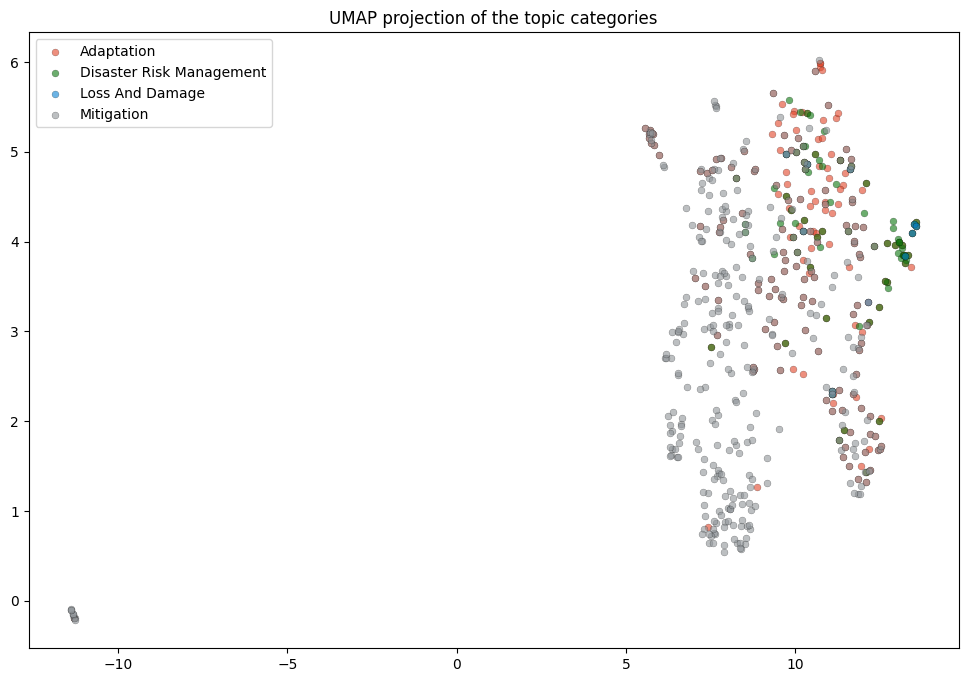

In [53]:
# Assuming 'embeddings' is your original high-dim embeddings (not 2D UMAP)
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.2)  # to expect ~20% points as outliers with a tigher local neighbourhood
outlier_flags = lof.fit_predict(X_test)  # -1 for outliers, 1 for inliers

# Keep only inliers
inlier_mask = outlier_flags == 1
filtered_embeddings = X_test[inlier_mask]
filtered_labels = y_true[inlier_mask]

# Run UMAP on filtered embeddings

reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
embedding_2d = reducer.fit_transform(filtered_embeddings)

# Plot with filtered labels
label_list = list(mlb.classes_)  # or your label list
palette = ['#e24428', '#0b770e', '#0b81d3', '#909599',]#sns.color_palette("Set2", n_colors=len(label_list))
label_colors = {label: color for label, color in zip(label_list, palette)}

plt.figure(figsize=(12,8))
for label in label_list:
    i = label_list.index(label)
    idx = np.where(filtered_labels[:, i] == 1)[0]
    plt.scatter(embedding_2d[idx, 0], embedding_2d[idx, 1], label=label, alpha=0.6, s=25,
        color=label_colors[label],
        edgecolors='k',
        linewidths=0.2)

plt.legend()
plt.title('UMAP projection of the topic categories')
plt.savefig("../images/umap_projection.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [47]:
custom_palette = {
    'Adaptation': '#e24428',
    'Disaster Risk Management': '#0b770e',
    'Loss And Damage': '#0b81d3',
    'Mitigation': '#909599'
}

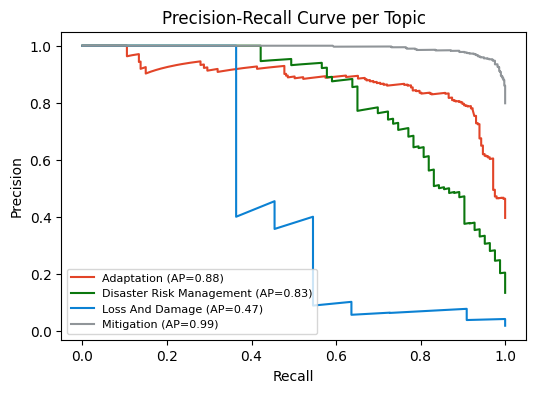

In [54]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(6, 4))

for i, label in enumerate(mlb.classes_):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred_probs[:, i])
    ap = average_precision_score(y_true[:, i], y_pred_probs[:, i])
    color = custom_palette.get(label, None)  # fallback to default if label not in palette
    plt.plot(recall, precision, label=f'{label} (AP={ap:.2f})', color=color)


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per Topic')
plt.legend(loc='lower left', fontsize=8)
plt.savefig("../images/precision_recall.pdf", format='pdf', bbox_inches='tight')
plt.show()


/tmp/ipykernel_678680/4111885223.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


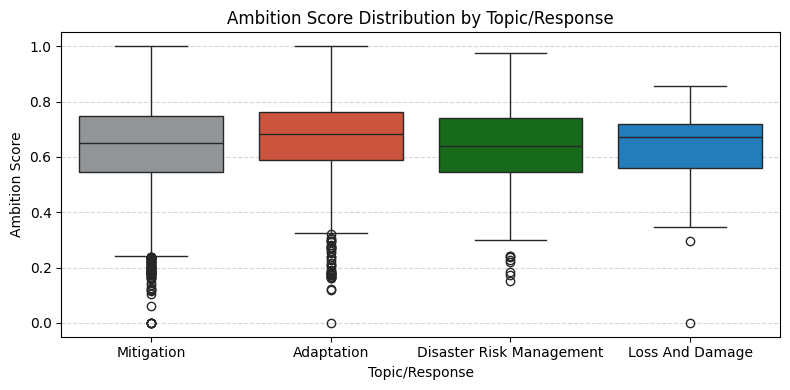

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming:
# df is your DataFrame
# df['Topic/Response'] contains multi-labels (e.g. "Mitigation;Adaptation")
# df['Ambition Score'] is a float value

# Explode multi-labels into individual rows
df_exploded = df.copy()
df_exploded['Topic/Response'] = df_exploded['Topic/Response'].str.split(';')
df_exploded = df_exploded.explode('Topic/Response')
df_exploded['Topic/Response'] = df_exploded['Topic/Response'].str.strip()

# Define a custom color palette (match number of unique labels)
unique_labels = df_exploded['Topic/Response'].unique()


# Create the boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=df_exploded,
    x='Topic/Response',
    y='ambition_score',
    palette=custom_palette
)

plt.title('Ambition Score Distribution by Topic/Response')
plt.ylabel('Ambition Score')
plt.xlabel('Topic/Response')
plt.xticks()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../images/ambition_score.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [34]:
# Calculate word counts per summary (assuming 'Family Summary' column contains text)
word_counts = df['Family Summary'].apply(lambda x: len(str(x).split()))

# Filter rows with less than 50 words
#short_summaries = df[word_counts < 50] # 1409 
#short_summaries = df[word_counts < 40] # 998
#short_summaries = df[word_counts < 30] #612
#short_summaries = df[word_counts < 20] #270
short_summaries = df[word_counts < 10] # 34
short_summaries

,Document ID,Document Title,Family ID,Family Title,Family Summary,Collection Title(s),Collection Description(s),Document Variant,Document Content URL,Language,...,Topic/Response,Hazard,Sector,Keyword,Instrument,Author,Author Type,Tokens,ambition_score,labels
124,eleventh-five-year-development-plan_f156,Eleventh Five Year Development Plan,eleventh-five-year-development-plan_2b61,Eleventh Five Year Development Plan,<p>Eleventh Five Year Development Plan</p>,NaN,NaN,Original Language,https://www.sbb.gov.tr/wp-content/uploads/2022...,English,...,Mitigation,NaN,Economy-wide,Energy Efficiency;Renewables;Mitigation,"Processes, plans and strategies|Governance",NaN,NaN,Eleventh Five Year Development Plan,0.223756,[Mitigation]
163,basic-policy-for-nuclear-research-and-developm...,Basic Policy for Nuclear Research and Developm...,basic-policy-for-nuclear-research-and-developm...,Basic Policy for Nuclear Research and Developm...,<p>Basic Policy for Nuclear Research and Devel...,NaN,NaN,Translation,https://www.aec.go.jp/kettei/kettei/20170720_e...,English,...,Mitigation,NaN,Energy,Mitigation,"Research & Development, knowledge generation|I...",NaN,NaN,Basic Policy for Nuclear Research and Developm...,0.215429,[Mitigation]
256,resolution-520-2018-on-regulation-of-solar-the...,Resolution 520/2018 on Regulation of solar the...,resolution-520-2018-on-regulation-of-solar-the...,Resolution 520/2018 on Regulation of solar the...,<p>Resolution 520/2018</p>,NaN,NaN,Original Language,https://climateactiontracker.org/documents/540...,English,...,Mitigation,NaN,Buildings;Energy,Buildings;Heat;Energy;Renewables,Subsidies|Economic;Climate finance tools|Economic,NaN,NaN,Resolution 520/2018,0.157005,[Mitigation]
257,strategy-for-the-development-of-the-automotive...,Strategy for the development of the automotive...,strategy-for-the-development-of-the-automotive...,Strategy for the development of the automotive...,<p>Order from 28 April 2018</p>,NaN,NaN,Original Language,http://static.government.ru/media/files/EVXNIp...,Russian,...,Mitigation,NaN,Transport,Mitigation;Transport,Other|Governance,NaN,NaN,Order from 28 April 2018,0.114157,[Mitigation]
390,amendment-to-executive-decree-no-676-of-februa...,Amendment to Executive Decree No. 676 of Febru...,decrees-reform-the-program-to-reduce-environme...,Decrees: Reform The Program To Reduce Environm...,This decree contains specific provisions relat...,NaN,NaN,Original Language,https://eur-lex.europa.eu/legal-content/EN/TXT...,English;English,...,Mitigation,NaN,Residential and Commercial;Transport;Energy,Energy Demand,"Tax incentives|Economic;Processes, plans and s...",NaN,NaN,This decree contains specific provisions relat...,0.235933,[Mitigation]
916,law-no-18-719-approving-the-national-budget-20...,Law no. 18.719 Approving the National Budget 2...,law-no-18-719-approving-the-national-budget-20...,Law no. 18.719 Approving the National Budget 2...,"<p>Has references to climate change, mitigatio...",NaN,NaN,Original Language,https://climate-laws.org/rails/active_storage/...,Spanish;Spanish,...,Adaptation,NaN,NaN,Adaptation;Institutions / Administrative Arran...,Provision of climate funds|Direct Investment,NaN,NaN,"Has references to climate change, mitigation a...",0.388560,[Adaptation]
1082,taxonomy_2e03,Taxonomy,mexico-s-taxonomy-on-sustainable-activities_a920,Mexico's Taxonomy on Sustainable Activities,This document sets out Mexico's taxonoy on sus...,NaN,NaN,NaN,https://www.sbfnetwork.org/wp-content/uploads/...,Spanish,...,Mitigation,NaN,NaN,Taxonomy;Finance,NaN,NaN,NaN,This document sets out Mexico's taxonoy on sus...,0.210136,[Mitigation]
1085,georgie-s-sustainable-finance-taxonomy_bb01,Georgie's Sustainable Finance Taxonomy,georgie-s-sustainable-finance-taxonomy_d6da,Georgie's Sustainable Finance Taxonomy,This document sets out Georgie's Sustainable F...,NaN,NaN,NaN,https://nbg.gov.ge/fm/%E1%83%A4%E1%83%98%E1%83...,English,...,Mitigation,NaN,Finance;Cross Cutting Area,Taxonomy,NaN,NaN,NaN,This document sets o